In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time

device = torch.device("cuba:0" if torch.cuda.is_available() else "cpu") # device object

### Loading the dataset

In [2]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print("Size of Train dataset:", len(train_datasets))
print("Size of Test dataset:", len(test_datasets))

class_names = train_datasets.classes
print("Classes:", class_names)

Size of Train dataset: 960
Size of Test dataset: 242
Classes: ['Clement Lenglet', 'Cristian Romero', 'Dejan Kulusevski', 'Emerson Royal', 'Eric Dier', 'Harry Kane', 'Heung-Min Son', 'Hugo Lloris', 'Ivan Perisic', 'Richarlison', 'Rodrigo Bentancur', 'Yves Bissouma']


### Image Visualization

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

/Users/iriskim/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


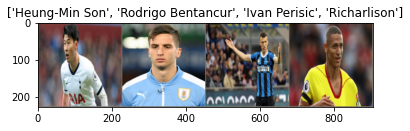

In [5]:
def imshow(input, title):
    # transforming torch.Tensor to a numpy object
    input = input.numpy().transpose((1, 2, 0))
    
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    
    # show image
    plt.imshow(input)
    plt.title(title)
    plt.show()
    
# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

- 학습할 CNN 딥러닝 모델 객체 초기화하기

In [6]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/Users/iriskim/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/iriskim/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/iriskim/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))